# Olist E-commerce: Feature Engineering & Exploratory Analysis

**Author:** Zeeshan Akram <br>
**Date:** November 2025 <br>
**Project:** Olist E-commerce Performance & Profitability Analysis

---

## 1. Objective

The goal of this notebook is to transform the clean, merged dataset into a feature-rich table ready for deep analysis. I will perform exploratory data analysis (EDA) to uncover actionable, business-oriented insights across the key pillars of the operation.

My focus will be on **identifying key drivers, patterns, and anomalies** related to:
* **Logistics & Customer Satisfaction:** How does operational performance impact customer perception?
* **Product & Seller Performance:** Which products and sellers are driving profitability, and which are a drain on the business?
* **Customer Behavior & Value:** What are the purchasing patterns and geographical trends of our customers?

## 2. Data Source

I am loading the final, cleaned, and merged dataset created in the `01_Data_Cleaning_and_Integration` notebook.

* **File Path:** `../outputs/master_data.csv`

## Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [5]:
df = pd.read_csv('../outputs/cleaned_data.csv')
# preview
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,customer_city,customer_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,sao paulo,SP,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,barreiras,BA,400.0,19.0,13.0,19.0,perfumery,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,vianopolis,GO,420.0,24.0,19.0,21.0,auto,14840.0,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,...,sao goncalo do amarante,RN,450.0,30.0,10.0,20.0,pet_shop,31842.0,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,...,santo andre,SP,250.0,51.0,15.0,15.0,stationery,8752.0,mogi das cruzes,SP


## Handling Missing Values (NaNs)

A key part of my strategy is to **intentionally keep** the `NaN` values at this stage.

My `LEFT` joins correctly preserved all original orders, and the resulting `NaN`s are not errors; they represent real-world business scenarios. Dropping them would remove critical insights and bias the analysis.

* **Logistics NaNs** (e.g., `order_delivered_customer_date`) represent **canceled or failed deliveries**. These are essential for analyzing delivery failures.
* **Item NaNs** (e.g., `product_id`, `price`) represent the **775 orders that had no items**.
* **Review NaNs** (e.g., `review_score`) represent **orders that were never reviewed**.

My plan is to handle these `NaN`s during the analysis (e.g., `df[df['review_score'].notnull()]`) rather than dropping them now.

## Feature Engineering

My first step in the analysis phase is to engineer new features from the existing data. These features are designed to convert raw data (like timestamps and prices) into actionable business metrics.

### Logistics Funnel Features

I am breaking down the total order time into four key components to pinpoint specific bottlenecks in the fulfillment process.

* **`approval_time`**
    * **Calculation:** `order_approved_at` - `order_purchase_timestamp`
    * **Business Purpose:** Measures the efficiency of the payment system. A long approval time can lead to early customer frustration.

* **`processing_time`**
    * **Calculation:** `order_delivered_carrier_date` - `order_approved_at`
    * **Business Purpose:** This is the **Seller's Lag**. It measures how long it takes the seller to prepare, pack, and hand the order to the shipping partner.

* **`shipping_time`**
    * **Calculation:** `order_delivered_customer_date` - `order_delivered_carrier_date`
    * **Business Purpose:** This is the **Shipper's Lag**. It isolates the performance of the logistics partner.

* **`delivery_delta`**
    * **Calculation:** `order_estimated_delivery_date` - `order_delivered_customer_date`
    * **Business Purpose:** This is the **most critical satisfaction feature**. A positive value means the order arrived *early*; a negative value means it arrived *late*.

### Customer Friction Feature

I am creating one feature to measure the financial impact of shipping on the customer's purchase.

* **`freight_ratio`**
    * **Calculation:** `freight_value` / `price`
    * **Business Purpose:** This feature measures **customer price sensitivity**, *not* profit. It calculates what percentage of the item's cost the customer had to pay *on top* for shipping. A high ratio (e.g., 0.5) means the shipping cost was 50% of the item's price, which is a major friction point and a strong potential driver of low `review_score`s.

## Again Converting to DateTime

In [9]:
date_cols = ['order_approved_at', 'order_purchase_timestamp', 'order_delivered_carrier_date', 
             'order_delivered_customer_date','order_estimated_delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

## Approval Time Feature

In [87]:
## creating features

df['approval_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days.astype('UInt8')

### Processing Time Feature

In [28]:
# It has negative values
df['processing_time'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.days.astype("Int16")

In [30]:
df['processing_time'].apply(lambda x: "Negative" if x<0 else "Positive").value_counts()

processing_time
Positive    111874
Negative      1551
Name: count, dtype: int64

In [42]:
df['processing_time'][(df['processing_time'] < 0)] = 0

## Handling Logical Errors

While engineering the `processing_time` (`order_delivered_carrier_date` - `order_approved_at`), I discovered a significant data integrity issue.

* **Finding:** 1,551 records (about 1.4%) had a **negative processing time**. This is logically impossible, as it implies the seller shipped the item *before* the payment was approved.
* **Analysis:** This is dirty data, likely caused by a lag in the payment approval timestamp being recorded.
* **Action:** To neutralize these impossible values without dropping the rows, I will **impute all negative processing times to 0**. This assumes a best-case scenario (instant processing) and corrects the logical error.

### Shipping Time Feature

In [56]:
df['shipping_time'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']).dt.days.astype("Int16")

In [59]:
df['shipping_time'].apply(lambda x: 'Negative' if x<0 else 'Positive').value_counts()

shipping_time
Positive    113375
Negative        50
Name: count, dtype: int64

In [64]:
df.shape

(113425, 31)

In [73]:
# dropping these 50 rows
df = df[(df['shipping_time'] >= 0) | (df['shipping_time'].isna())]

In [74]:
## New shape
df.shape

(113375, 31)

## Handling Logical Errors (Shipping)

While engineering the `shipping_time` (`order_delivered_customer_date` - `order_delivered_carrier_date`), I discovered a second data integrity issue.

* **Finding:** 50 records had a **negative shipping time**, implying the customer received the package before the carrier scanned it as "picked up."
* **Analysis:** This is a data-logging error. The number of affected rows (50, or 0.04% of the dataset) is statistically insignificant.
* **Action:** I will **drop these 50 rows** from the dataset. This is a cleaner solution than imputation, as it completely removes the logically impossible records and prevents them from skewing the analysis of shipping performance.

## Delivery Delta Feature

In [84]:
df['delivery_delta'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days.astype("Int16")

In [86]:
df['delivery_delta'].apply(lambda x: 'Negative' if x<0 else 'Positive').value_counts()

delivery_delta
Positive    104660
Negative      8715
Name: count, dtype: int64

## The `delivery_delta` Insight

While engineering the `delivery_delta` (`estimated_delivery_date` - `order_delivered_customer_date`), I identified two distinct groups.

* **Finding:**
    * **104,660** records had a **positive or zero** value (delivered on time or early).
    * **8,715** records had a **negative** value (delivered late).

* **Analysis:** This is **not a data error**. Unlike the previous time-based features, a negative `delivery_delta` is a real-world, logical outcome.
* **Justification:** These 8,715 rows are the **core of my customer satisfaction analysis**. They represent all the orders that failed to meet the delivery promise. I will not be "fixing" or dropping these rows.
* **Next Step:** This feature is now ready. My hypothesis is that these negative values will have a strong negative correlation with `review_score`.

### Freight Ratio Feature

In [89]:
df['freight_ratio'] = df['freight_value']/df['price']

In [90]:
## preview
df['freight_ratio'].sample(5)

63716    0.273660
20739    0.095314
91639    0.562174
39706    0.328270
4946     0.233727
Name: freight_ratio, dtype: float64

## Feature Engineering: `freight_ratio`

I have successfully created the `freight_ratio` (`freight_value` / `price`).

* **Purpose:** This feature measures **customer price sensitivity**. A high ratio (e.g., 0.56, as seen in the sample) indicates the shipping cost was 56% of the item's price.
* **Next Step:** This is ready for analysis. My hypothesis is that a high `freight_ratio` is a major point of friction and will correlate with low `review_score`s.

In [104]:
df['purchase_month'] = df['order_purchase_timestamp'].dt.month_name()
df['purchase_day_of_week'] = df['order_purchase_timestamp'].dt.day_of_week
df['purchase_hour'] = df['order_purchase_timestamp'].dt.strftime('%I %p').astype('category')

## Feature Engineering: Purchase Time Analysis

To understand customer purchasing patterns, I extracted key date and time components from the `order_purchase_timestamp`. This is not for complex time-series forecasting but for **descriptive pattern analysis** to answer core business questions about *when* customers shop.

* **`purchase_month`**
    * **Action:** Extracted the month name (e.g., "January", "February").
    * **Business Purpose:** This allows for a high-level view of seasonality and helps identify peak sales months.

* **`purchase_day_of_week`**
    * **Action:** Extracted the day of the week (where 0=Monday, 6=Sunday).
    * **Business Purpose:** This helps me analyze the weekly demand cycle and answer whether customers shop more on weekdays or weekends, which is vital for marketing.

* **`purchase_hour`**
    * **Action:** Extracted the hour and converted it to a 12-hour AM/PM format (e.g., "09 AM", "10 PM") and stored it as a `category`.
    * **Business Purpose:** This is crucial for identifying peak purchasing hours. This insight can inform decisions on server load, customer service staffing, and ad-spend timing.

In [116]:
conditions = [df['order_delivered_customer_date'].isna(),
             (df['delivery_delta'].notna()) & (df['delivery_delta'] < 0),
              (df['delivery_delta'].notna()) & (df['delivery_delta'] >= 0)]

choices = [
    'Not Delivered',
    'Delivered Late',
    'Delivered On Time'
]

df['delivery_status'] = np.select(condlist=conditions, choicelist=choices, default="Unknown")

## Feature Engineering: Handling `delivery_delta` NaNs

My calculation of `delivery_delta` resulted in 3,229 `NaN` values.

* **Analysis:** This is the correct and expected behavior. These `NaNs` are not errors; they are a direct result of the `NaNs` in the `order_delivered_customer_date` column.
* **Justification:** These 3,229 rows represent all orders that were **"Not Delivered"** (e.g., canceled, unavailable, lost in transit). They cannot have a delivery delta.
* **Action:** I will not drop or impute these values. Instead, I will **use these `NaNs` as the first condition** to create my new categorical `delivery_status` feature. This explicitly labels this cohort, turning the missing data into a valuable insight.

In [118]:
df['delivery_status'].value_counts()

delivery_status
Delivered On Time    101431
Delivered Late         8715
Not Delivered          3229
Name: count, dtype: int64

## Feature Engineering: `delivery_status` (Categorical)

To complement the quantitative `delivery_delta` feature, I am creating a categorical `delivery_status` feature. This "business-friendly" bucket is essential for high-level grouping, segmentation, and dashboard visualizations.

* **Action:** I will create a new column by applying logic in the following order:
    1.  If `order_delivered_customer_date` is `NaN`, set status to **"Not Delivered"**.
    2.  Else, if `delivery_delta` is negative, set status to **"Delivered Late"**.
    3.  Else, set status to **"Delivered On Time"**.

* **Business Purpose:** This feature will be a central pillar of my analysis, allowing me to directly compare the business impact (e.g., review scores, total revenue) across these three critical delivery outcomes.

# Exploratory Data Analysis(EDA)

### Quick Overview

In [120]:
print("Shape of data:", df.shape)
print("\nPreview")
display(df.sample(5))

Shape of data: (113375, 37)

Preview


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,seller_state,processing_time,approval_time,shipping_time,delivery_delta,freight_ratio,purchase_month,purchase_hour,purchase_day_of_week,delivery_status
25907,13672bbd5446ca25fe82ddc218f81a3a,97efeb58e92886e9de1ab49ce06a8139,delivered,2018-05-14 21:43:39,2018-05-14 21:57:58,2018-05-15 13:17:00,2018-05-16 16:18:54,2018-05-25,c2a9a78ad1d9a0546b72e6889c999e75,5a6a02f419701fc8c605af71d4fc57a4,...,SP,0,0,1,8,0.185213,May,09 PM,0,Delivered On Time
57210,6b8e33e6751e356214e7b35ad7df83cb,b083efa0cd26465439a0c966b960a701,delivered,2018-06-21 19:24:06,2018-06-21 19:38:39,2018-06-22 15:16:00,2018-06-29 20:16:46,2018-07-19,99ba5fbf3ae895fe3a9289acd0a5eb91,562fc2f2c2863ab7e79a9e4388a58a14,...,SP,0,0,7,19,0.459615,June,07 PM,3,Delivered On Time
8042,0b446830af3811ef0d7c2e0db238af50,c180879e74d4c16ff6a311d185440de6,delivered,2017-09-02 15:44:30,2017-09-02 15:55:12,2017-09-05 15:47:58,2017-09-11 17:42:21,2017-09-21,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,...,SP,2,0,6,9,0.180868,September,03 PM,5,Delivered On Time
58447,3e851df052741b8294183d372f0bf1a2,79c9f17f45207ca205c42da2b03a7359,delivered,2018-01-04 22:52:45,2018-01-04 23:07:54,2018-01-05 22:29:24,2018-01-23 17:29:10,2018-01-31,494509de79a69ffbc694af3e4b1bd929,f45122a9ab94eb4f3f8953578bc0c560,...,SP,0,0,17,7,0.444248,January,10 PM,3,Delivered On Time
74251,8ac5b235603eee2e21e36261b2df536c,2ea5983ec2edde5dcba726ea64e9fadb,delivered,2017-11-27 11:26:14,2017-11-27 11:35:41,2017-11-30 16:41:39,2017-12-05 21:32:09,2017-12-20,5aad359a63cbb4fc35ead44346a3eeb4,d20b021d3efdf267a402c402a48ea64b,...,SP,3,0,5,14,0.799818,November,11 AM,0,Delivered On Time


In [122]:
## total unique orders
print("Total Unique Orders: ", df['order_id'].nunique())
## total unique customers
print("Total Unique Customers: ", df['customer_unique_id'].nunique())
## total unique sellers
print("Total Unique Sellers: ", df['seller_id'].nunique())
## total product categories
print("Total Unique Categories: ", df['product_category'].nunique())

Total Unique Orders:  99418
Total Unique Customers:  96076
Total Unique Sellers:  3093
Total Unique Categories:  72


## Exploratory Data Analysis (EDA) - High-Level Summary

Before diving into specific questions, I will establish a high-level statistical baseline of my final, feature-rich master DataFrame. This provides the overall context for the analysis.

* **Total Order Items (Rows):** `113375`
* **Total Unique Orders:** `99418`
* **Total Unique Customers:** `96076`
* **Total Unique Sellers:** `3093`
* **Total Product Categories:** `72`

## Outliers & Distribution Patterns

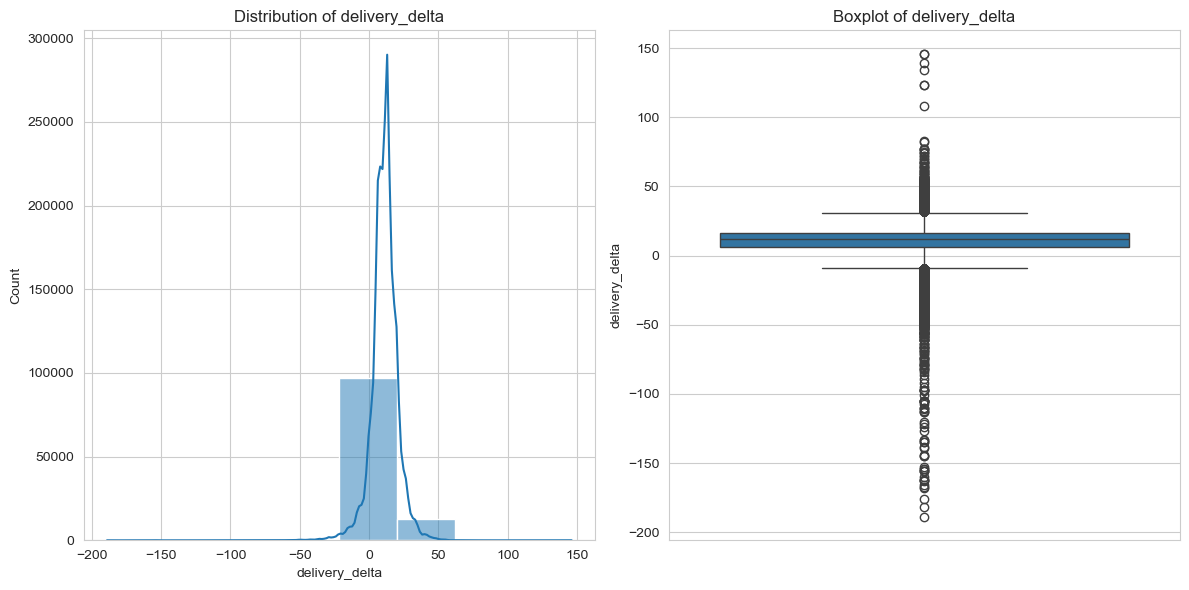

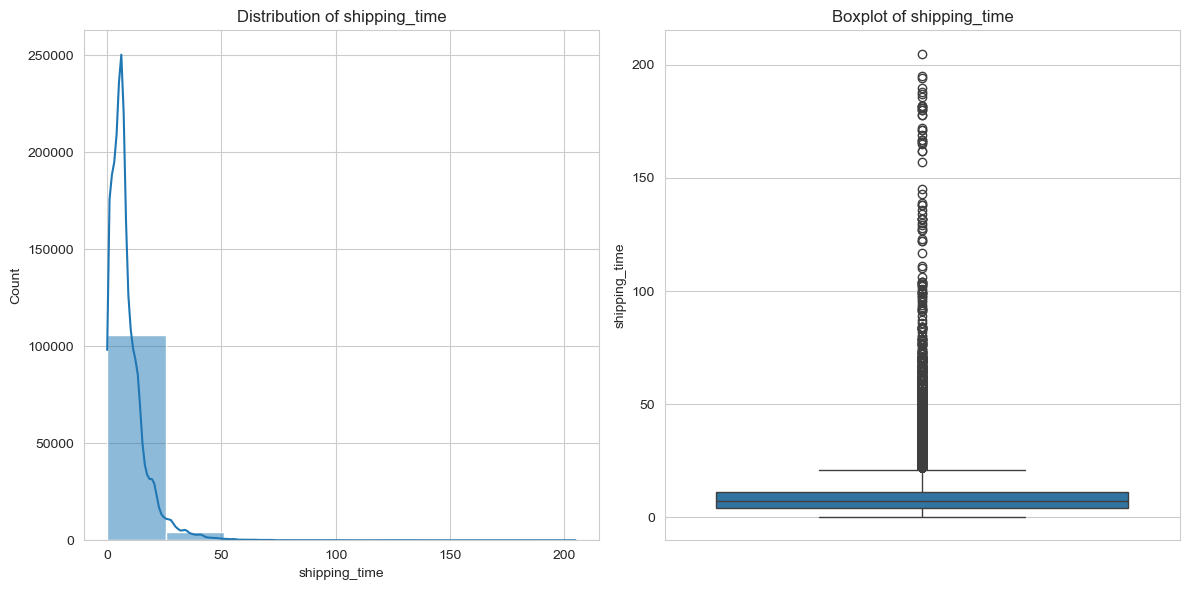

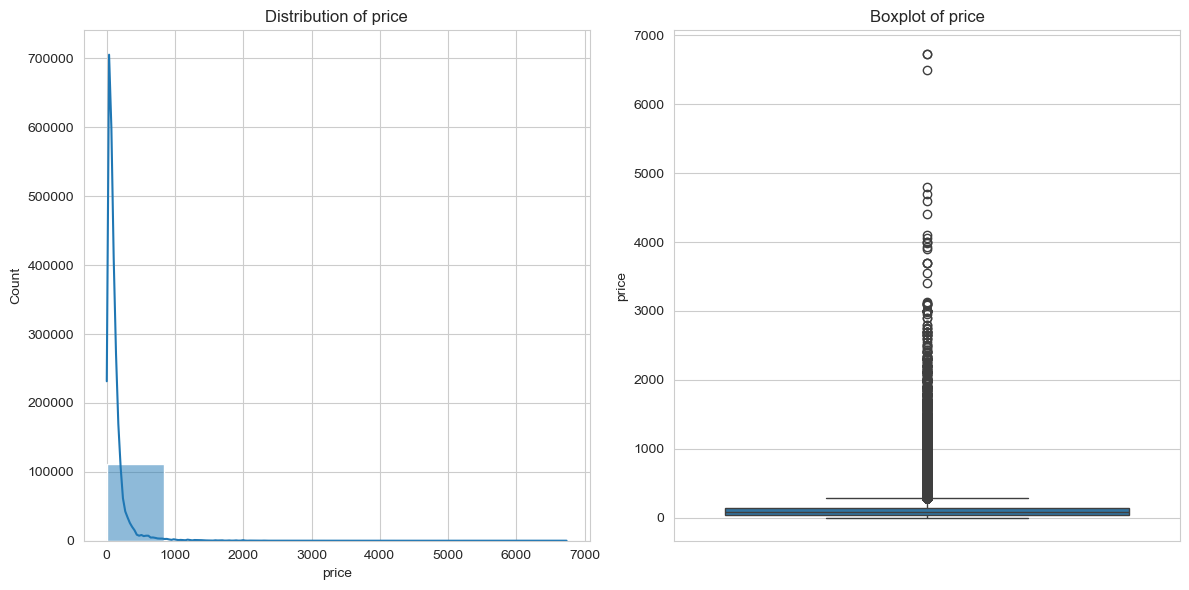

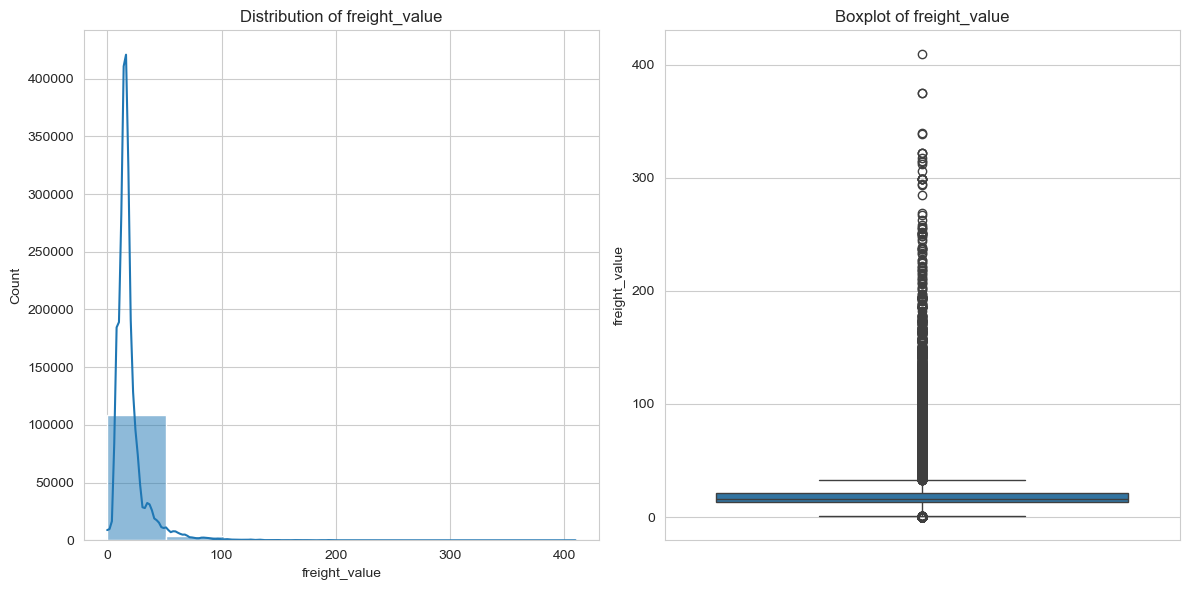

In [132]:
sns.set_style('whitegrid')
cols_to_plot = ['delivery_delta', 'shipping_time', 'price', 'freight_value']
for col in cols_to_plot:
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    # histplot with kde
    sns.histplot(df[col], kde=True, ax=axes[0], bins=8)
    axes[0].set_title(f"Distribution of {col}")
    
    # boxplot
    sns.boxplot(df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    plt.tight_layout()

## Univariate Distribution Analysis

My first step is to understand the "shape" of my key numerical features. I am checking for skewness and outliers to understand the fundamental patterns of the business.

### Key Insights from Distributions

* **`delivery_delta` (Satisfaction Driver):**
    The distribution is centered positively, with a median around +10 days. This is a key insight: **most orders are delivered well *before* the estimated date**. However, the plot shows a significant and long "late" tail, with outliers extending to -200 days. These negative values are not errors; they represent the **critical cohort of dissatisfied customers** I must analyze.

* **`shipping_time` (Logistics Performance):**
    This distribution is heavily right-skewed. The vast majority of shipments are fast (median < 10 days), but the process is highly inconsistent. The extreme outliers, with some items taking over 200 days in transit, show a **long tail of critical logistics failures**.

* **`price` & `freight_value` (Business Model):**
    Both plots are extremely right-skewed. The business is fundamentally built on a **high volume of low-cost items**.
    * **Price:** The median price is low (under 100 BRL), with a small number of very expensive luxury/bulk items.
    * **Freight:** The median freight cost is also low (under 20 BRL), with a few extreme outliers for heavy/long-distance items.

## Does delivery performance actually impact customer satisfaction?

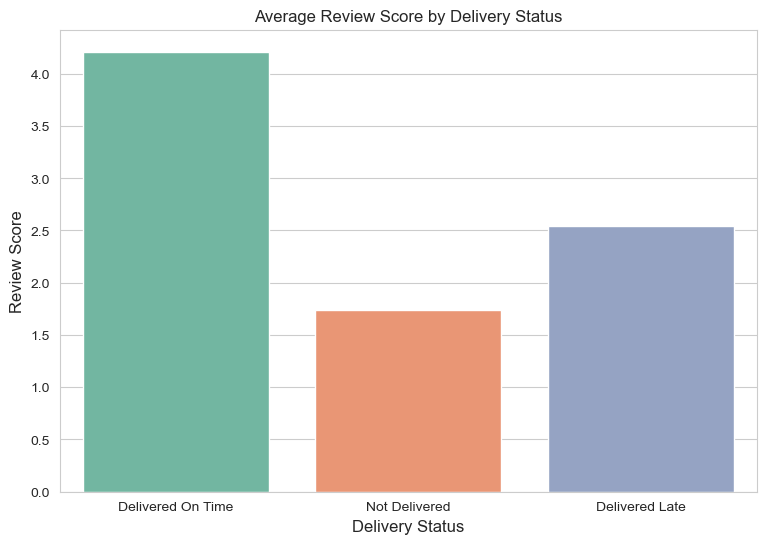

In [299]:
plt.figure(figsize=(9,6))
sns.barplot(data=df, x='delivery_status', y='review_score', palette='Set2', errorbar=None)
plt.title("Average Review Score by Delivery Status")
plt.xlabel("Delivery Status", fontsize=12)
plt.ylabel("Review Score", fontsize=12)
plt.savefig("../images/average_review_by_del_status.png", dpi=300)
plt.show()

## EDA: Impact of Delivery Status on Review Score (Core Insight)

This analysis is the cornerstone of the project, directly linking logistics performance to customer satisfaction.

* **Finding 1: On-Time vs. Late:** Orders `Delivered On Time` have a high average review score of **~4.2**. In sharp contrast, orders that are `Delivered Late` have their score cut almost in half, to **~2.5**.

* **Finding 2: Failed Deliveries:** The `Not Delivered` cohort (e.g., canceled, lost) has the lowest average score of **~1.7**. This is not a product review; it's a direct measure of customer dissatisfaction with the fulfillment process itself.

* **Business Impact:** The data proves that **logistics performance is the single most important driver of customer satisfaction**. A late or failed delivery is the primary predictor of a 1- or 2-star review, regardless of product quality.

### Review Score by Delivery Delta

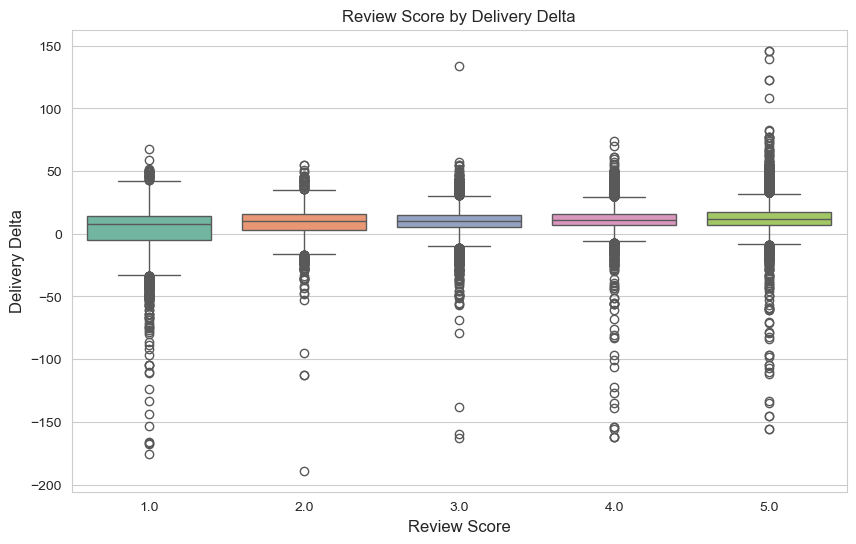

In [160]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='review_score', y='delivery_delta', palette='Set2')
plt.title("Review Score by Delivery Delta")
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Delivery Delta", fontsize=12)
plt.show()

## EDA: Review Score vs. Delivery Delta (The Quantitative Proof)

This plot provides the quantitative proof for my first insight. It shows the *distribution* of delivery performance for each specific review score.

* **Finding 1 (The Clear Trend):** The plot shows a clear monotonic relationship.
    * **1-Star & 2-Star** reviews are dominated by **late deliveries** (the median `delivery_delta` is low).
    * **4-Star & 5-Star** reviews are dominated by **on-time or early deliveries** (the median `delivery_delta` is positive).

* **Finding 2 (The "Noise" - A Key Insight):**
    I noted a significant number of outliers, particularly 4 and 5-star reviews for orders that were **extremely late** (e.g., -100 days). This is not an error.
* **Hypothesis:** This strongly suggests a disconnect in the review system. Customers are likely reviewing the **product** (giving it 5 stars) based on the store photos, possibly *before* the order has even arrived. The review score, therefore, is a mix of "product satisfaction" and "service satisfaction," but this chart proves that service is the dominant factor.

## Which part of the process is causing the most delays?

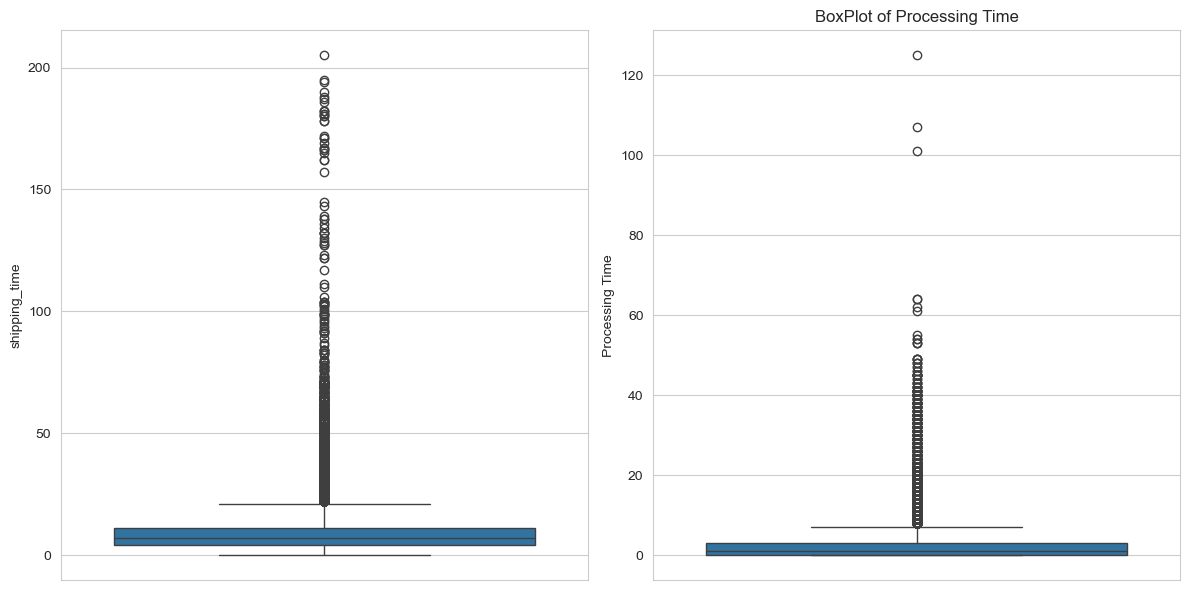

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

## for shipping time
sns.boxplot(data=df, y='shipping_time', ax=axes[0])
plt.title("BoxPlot of Shipping Time")
plt.ylabel("Shipping Time")

# for processing time
sns.boxplot(data=df, y='processing_time', ax=axes[1])
plt.title("BoxPlot of Processing Time")
plt.ylabel("Processing Time")

plt.tight_layout()
plt.show()

## EDA: Finding the Bottleneck (Processing vs. Shipping)

After proving that delays are the primary problem, I am now investigating *where* the delays originate. I am comparing `processing_time` (Seller's Lag) with `shipping_time` (Shipper's Lag).

* **Finding 1: The Medians are Deceivingly Good.**
    Both processes are *usually* fast. The `processing_time` median is extremely low (around 1 day), and the `shipping_time` median is also low (under 10 days). This shows that **50% of all items are processed and shipped quickly**.

* **Finding 2: The Outliers Reveal the True Problem.**
    Both plots show that the process is **highly inconsistent** and prone to failure, with outliers being the real issue.
    * **Seller Lag (`processing_time`):** While most sellers are fast, some take up to **120 days** just to hand the item to the shipper.
    * **Shipper Lag (`shipping_time`):** The logistics partners have an even more extreme "long tail" of failures, with some deliveries taking over **200 days** in transit.

* **Business Impact:** The problem isn't the average. The problem is the **unreliability** and the extreme outliers, which are the source of the 1-star reviews.

## Total Sales by Month

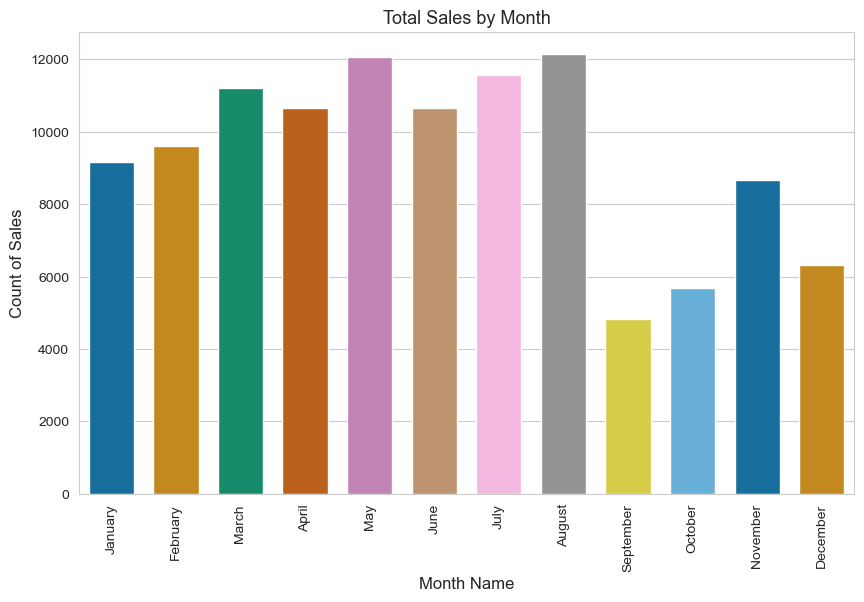

In [300]:
# data to plot
temp = df.groupby('purchase_month')['price'].count().reset_index()

# Ordering the month names
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
temp['purchase_month'] = pd.Categorical(temp['purchase_month'], categories=month_order, ordered=True)
temp_sorted = temp.sort_values('purchase_month')
temp_sorted = temp_sorted.rename(columns = {'price':'sales_count'})

# plotting
plt.figure(figsize=(10,6))
sns.barplot(data=temp_sorted, x='purchase_month', y='sales_count', palette='colorblind', width=0.7)
plt.title("Total Sales by Month", fontsize=13)
plt.xlabel("Month Name", fontsize=12)
plt.ylabel("Count of Sales", fontsize=12)
plt.xticks(rotation='vertical')
plt.savefig("../images/total_sales_by_month.png", dpi=300)
plt.show()

## EDA: Baseline Business Cycle (Monthly Seasonality)

I've plotted the total number of items sold by month to understand the fundamental business cycle.

* **Key Insight: The Black Friday Effect**
    My analysis shows that sales are generally strong from March to August. However, the most critical insight comes from the end of the year. While September and October see a significant dip, sales in **November** are strong, rivaling the mid-year peaks. This is not a random spike; this is a clear, actionable insight into the **massive impact of the Black Friday sales period**.

* **Hypothesis on Low-Performing Months:**
    The pronounced dip in September and October is likely a **data artifact**, not a business trend. The dataset starts in September 2016, meaning those months have less historical data than months like May or August (which appear in 2017 and 2018). The *real* story is the strength of November, which overcomes this data limitation to show a clear seasonal spike.

* **Business Impact:** The Black Friday spike is the single most important seasonal event. This finding has direct implications for inventory management, marketing spend, and server load capacity.

## Total Sales by Day of Week

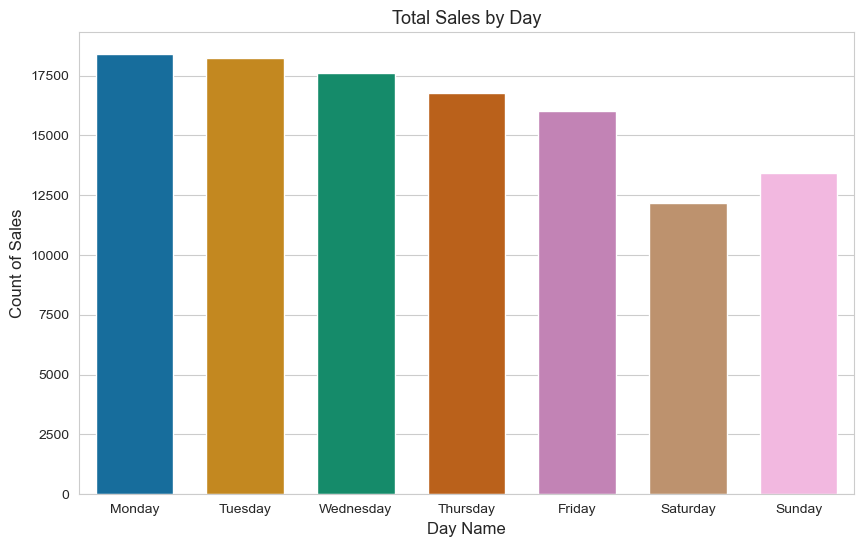

In [302]:
## mapping numbers to names
mapping_for_days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

## getting count of sales
temp_df = df.groupby('purchase_day_of_week')['price'].count().reset_index()
## mapping names of days
temp_df['purchase_day_of_week'] = temp_df['purchase_day_of_week'].map(mapping_for_days)
temp_df = temp_df.rename(columns={'price':'sales_count'})

# plotting
plt.figure(figsize=(10,6))
sns.barplot(data=temp_df, x='purchase_day_of_week', y='sales_count', palette='colorblind', width=0.7)
plt.title("Total Sales by Day", fontsize=13)
plt.xlabel("Day Name", fontsize=12)
plt.ylabel("Count of Sales", fontsize=12)
plt.savefig("../images/total_sales_by_day.png", dpi=300)
plt.show()

## EDA: Baseline Business Cycle (Weekly Demand)

I've plotted the total number of items sold by the day of the week to understand the weekly shopping cycle.

* **Key Insight: A "Weekday-Driven" Business Model**
    The plot clearly shows that Olist is not a weekend-shopping platform. Sales are **highest on Monday** and then show a consistent, steady **decline throughout the work week**.

* **The Weekend Drop-off:**
    Sales fall to their **lowest point on Saturday**, with a minor recovery on Sunday. This strong weekday-heavy pattern suggests that purchasing behavior may be more B2B (business-to-business) or "work-week" oriented rather than typical consumer impulse shopping.

* **Business Impact:** This insight is critical for marketing. Ad spend and promotions should be heavily weighted towards the start of the week (Mon-Wed) to capture peak demand, with potential "Weekend Flash Sales" needed to lift the underperforming Saturday.

## Total Sales by Hour

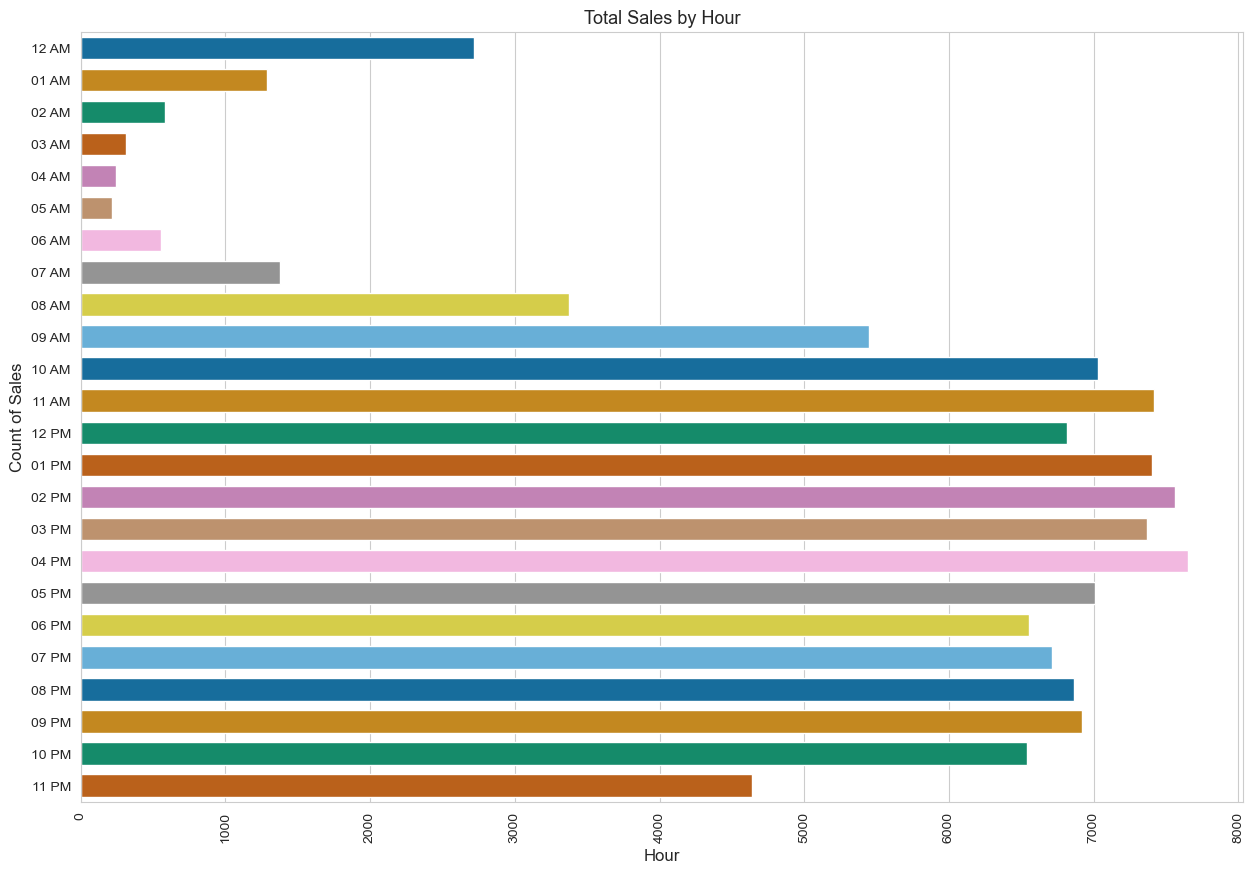

In [303]:
## getting count of sales per hour
temp_df = df.groupby('purchase_hour')['price'].count().reset_index()

# I need to sort this so all AM hours comes first
# creating key to sort data
temp_df['sort_key'] = pd.to_datetime(temp_df['purchase_hour'], format="%I %p")

## sorting data based on that key
temp_df = temp_df.sort_values(by='sort_key').drop('sort_key', axis=1)
temp_df = temp_df.rename(columns={'price':'sales_count'})

## hours order list for seaborn to plot in order
hours_order = temp_df['purchase_hour'].unique().to_list()

# plotting
plt.figure(figsize=(15,10))
sns.barplot(data=temp_df, y='purchase_hour', x='sales_count', palette='colorblind', width=0.7, order=hours_order)
plt.title("Total Sales by Hour", fontsize=13)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Count of Sales", fontsize=12)
plt.xticks(rotation='vertical')
plt.savefig("../images/total_sales_by_hour.png", dpi=300)
plt.show()

## EDA: Baseline Business Cycle (Daily Demand)

This horizontal bar chart reveals the 24-hour purchasing cycle of customers.

* **Key Insight 1: The "Dead Zone"**
    The business is effectively "asleep" from **1 AM to 6 AM**. This is not just a slowdown; it's a near-total drop in activity. This is the golden window for all server maintenance, database updates, and system patches that require downtime.

* **Key Insight 2: The Two "Prime Times"**
    The business does not have one peak; it has two:
    1.  **The Daytime Peak (10 AM - 5 PM):** A long, sustained, high-volume period. This is the "golden time" for the business, likely driven by work-week shoppers.
    2.  **The Evening Peak (6 PM - 10 PM):** A second, very strong peak, likely driven by at-home consumer shopping.

* **Business Impact:** This analysis provides a clear operational guide. Customer service and server capacity must be at 100% during the two peak periods, while all critical maintenance should be scheduled for the "Dead Zone."

## Initial EDA: Key Findings Summary

My exploratory analysis has revealed several critical, actionable insights into the business's operational performance and customer behavior.

### 1. The Core Insight: Logistics is the #1 Satisfaction Driver

My analysis proves that **delivery performance is the most important factor** in customer satisfaction.

* **The Problem:** Late deliveries are the primary predictor of 1- and 2-star reviews. Orders `Delivered On Time` have an average score of **~4.2**, while `Delivered Late` orders average **~2.5**.
* **The Cause:** The process is plagued by **unreliability**. While the *median* processing and shipping times are fast (1 and 10 days, respectively), a "long tail" of extreme failures (outliers up to 120-200 days) is the source of the delays and customer dissatisfaction.

### 2. The Business Model: High-Volume, Low-Cost

The univariate analysis shows the business is built on a high-volume, low-cost model.

* **Price & Freight:** Both distributions are heavily right-skewed, with the vast majority of items costing < 100 BRL and shipping for < 20 BRL.

### 3. The Business Cycle: A "Weekday" Operation

The business does not follow a typical weekend-consumer pattern.

* **Seasonality:** The business is seasonal, with a significant sales spike in **November (Black Friday)**.
* **Weekly Cycle:** It's a **"weekday-driven" business**. Sales peak on **Monday** and steadily decline, hitting their lowest point on Saturday.
* **Daily Cycle:** The business has two "prime times" (a daytime peak from 10 AM-5 PM and an evening peak from 6 PM-10 PM) and a clear "dead zone" (1 AM-6 AM) perfect for maintenance.

## Price vs Freight Value
- Is freight proportional to price?

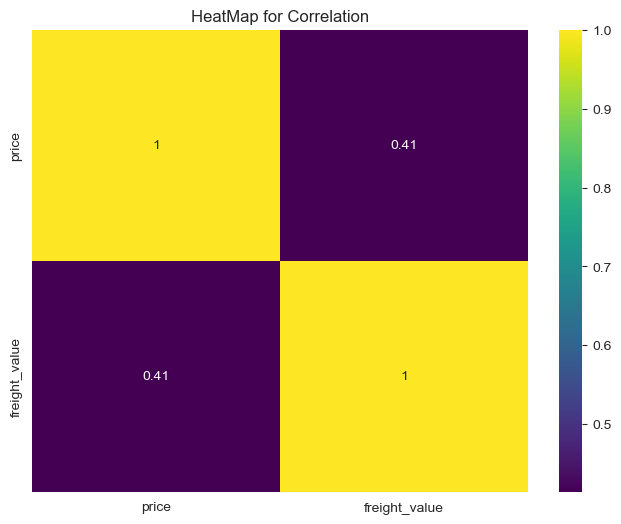

In [312]:
## heatmap for correlation
plt.figure(figsize=(8,6))
sns.heatmap(df[['price', 'freight_value']].corr(), annot=True, cmap='viridis')
plt.title("HeatMap for Correlation")
plt.show()

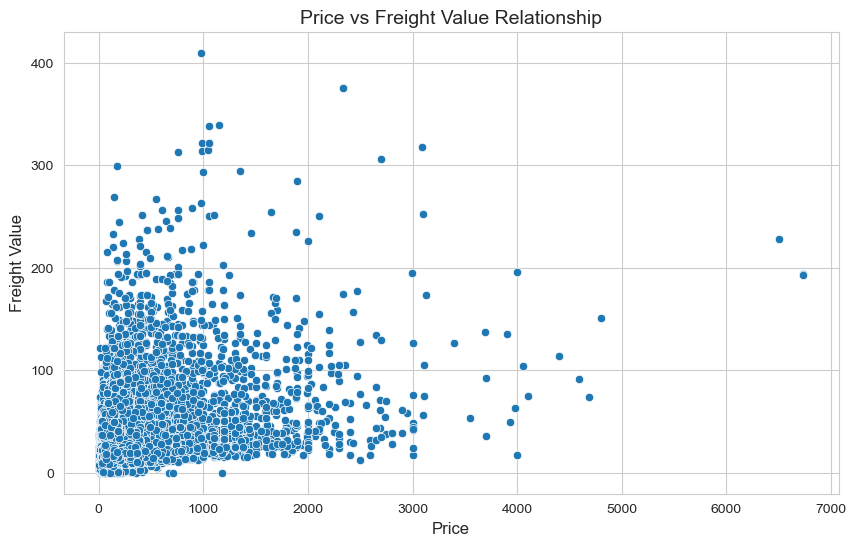

In [313]:
# plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='price', y='freight_value')
plt.title("Price vs Freight Value Relationship", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Freight Value", fontsize=12)
plt.savefig("../images/price_vs_freight.png", dpi=300)
plt.show()

## EDA: Price vs. Freight Value Relationship

My next analysis focuses on the item-level relationship between `price` and `freight_value` to understand shipping costs.

* **Finding 1: A Weak Correlation**
    The scatter plot shows a very "loose" relationship, which the heatmap confirms with a low correlation coefficient of **0.41**. This proves that `price` is **not** the primary driver of `freight_value`.

* **Finding 2: The "Customer Friction" Outliers**
    The plot clearly visualizes the "customer friction" I hypothesized. There are numerous instances of:
    * **High-Friction:** Low-price items (e.g., < 500 BRL) with extremely high freight costs (100-200+ BRL).
    * **Inefficiency:** High-price items (e.g., > 2000 BRL) with surprisingly low freight costs.

* **Business Impact:** This low correlation indicates an inconsistent and inefficient shipping cost structure. The "High-Friction" outliers are likely a major source of customer dissatisfaction and abandoned carts, as the `freight_ratio` on these items would be extremely high.

## Product & Seller Analysis
- What are our most popular product categories?

### Popular Categories

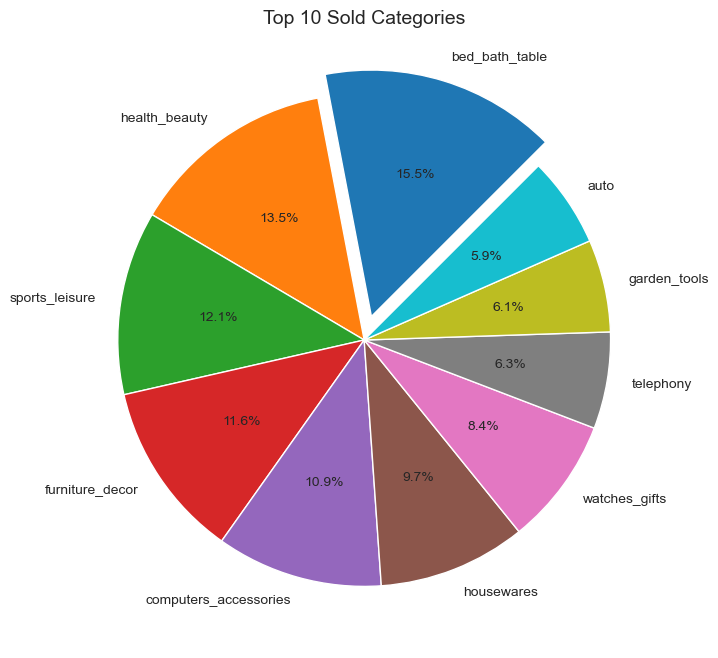

In [361]:
## calculate top 10 categories
top_categories = df.groupby('product_category')['order_id'].count().nlargest(10)

# colors list for pie chart
colors_list = sns.set_palette('tab10')
plt.figure(figsize=(8,8))
plt.pie(top_categories.values, labels=top_categories.index, autopct="%.1f%%", colors=colors_list, startangle=45, explode=[0.1,0,0,0,0,0,0,0,0,0])
plt.title("Top 10 Sold Categories", fontsize=14)
plt.savefig('../images/top_10_categories.png', dpi=300)
plt.show()

## EDA: Product Performance (Top 10 Categories by Volume)

My analysis now shifts to product performance. As a first step, I've identified the top 10 product categories based on the total number of items sold.

* **Key Insight: A Highly Diversified Business**
    The pie chart clearly shows that Olist is **not** a niche store. The business is highly diversified, with no single category dominating. The top 10 categories are all "lifestyle" or "home-oriented" products, with `bed_bath_table` (Home Goods) as the largest segment at 15.5%.

* **Observation:**
    The market share is spread fairly evenly across the top 7 categories (ranging from 15.5% down to 9.7%). This shows a healthy mix of products and no over-reliance on a single category for sales volume.

## Worst 10 Categories by Delivery

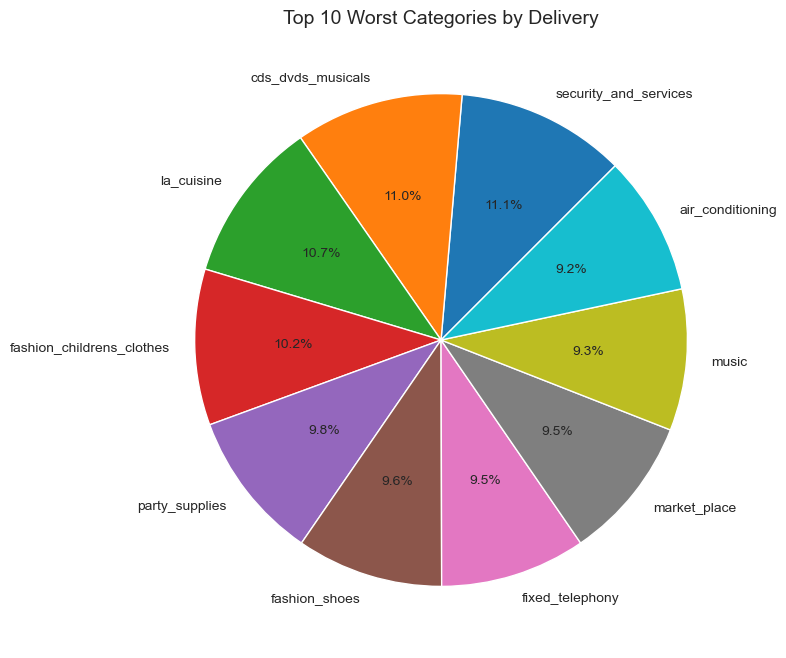

In [362]:
top_worst_categories = df.groupby('product_category')['delivery_delta'].mean().nlargest(10)

# colors list for pie chart
colors_list = sns.set_palette('tab10')
plt.figure(figsize=(8,8))
plt.pie(top_worst_categories.values, labels=top_worst_categories.index, autopct="%.1f%%", colors=colors_list, startangle=45)
plt.title("Top 10 Worst Categories by Delivery", fontsize=14)
plt.savefig('../images/top_worst_categories_by_delivery.png', dpi=300)
plt.show()

## Bar chart for actual percentages from whole data

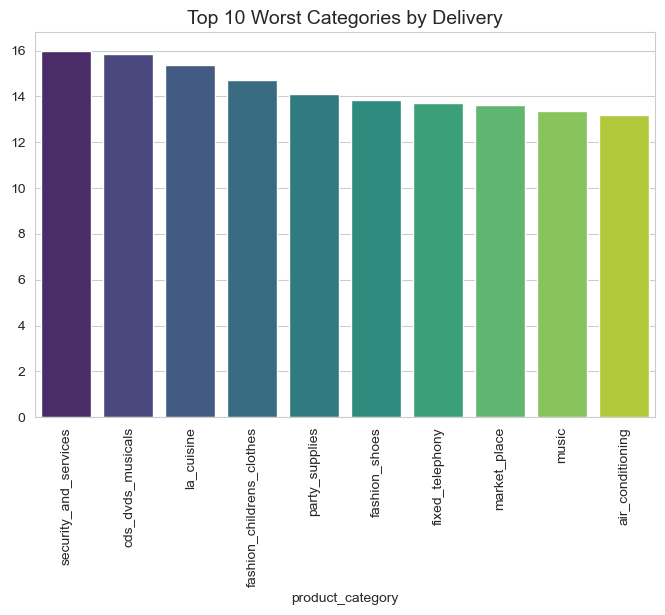

In [375]:
# bar plot for actual average rate
plt.figure(figsize=(8,5))
sns.barplot(y=top_worst_categories.values, x=top_worst_categories.index, palette='viridis', width=0.8)
plt.title("Top 10 Worst Categories by Delivery", fontsize=14)
plt.savefig('../images/top_worst_categories_by_delivery_bar.png', dpi=300)
plt.xticks(rotation='vertical')
plt.show()

## EDA: Product Performance

My goal was to identify which product categories have the worst delivery performance by analyzing the average `delivery_delta`.

### Initial Analysis & The Misleading Insight

I first plotted the "Top 10 Worst Categories" by average delay. The resulting bar chart was **highly misleading**.

* **The "Finding":** The chart showed `security_and_services` as the worst-performing category, with an average delay of **~16 days**.
* **The Critical Flaw:** I investigated the data behind this "insight." My analysis confirmed this category has **only 2 sales** in the entire 113k-row dataset. The "16-day delay" is based on a statistically insignificant sample size (*n*=2).

### Conclusion & New Action Plan

The initial analysis is contaminated by low-volume categories. I cannot make a credible business recommendation (e.g., "fix the `security_and_services` supply chain") based on two sales.

My next step must be to **filter out this noise**. To find the *true* problem categories, I will re-run this analysis with a crucial filter: I will only look at categories that have a **significant sales volume** (e.g., more than 100 or 500 sales). This will reveal the categories that are *both* popular *and* consistently delayed, which is the real, actionable insight.

## Top Worst Categories (n > 100)

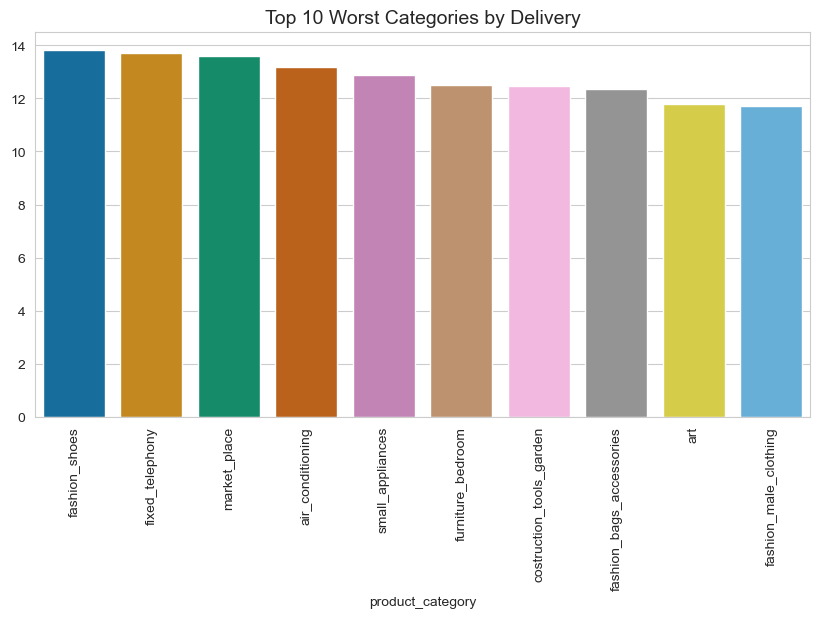

In [417]:
## getting categories with count > 100
temp_df = df['product_category'].value_counts().reset_index()
temp_df = temp_df[temp_df['count'] > 100]
top_categories = temp_df['product_category'].values
new_temp_df = df[df['product_category'].isin(top_categories)]

top_worst_categories = new_temp_df.groupby('product_category')['delivery_delta'].mean().nlargest(10)

# bar plot for actual average rate
plt.figure(figsize=(10,5))
sns.barplot(y=top_worst_categories.values, x=top_worst_categories.index, palette='colorblind', width=0.8)
plt.title("Top 10 Worst Categories by Delivery", fontsize=14)
plt.savefig('../images/top_worst_categories_by_delivery_bar_main.png', dpi=300)
plt.xticks(rotation='vertical')
plt.show()

## EDA: Product Performance

My initial analysis was contaminated by low-volume categories. I have now corrected this by filtering for **categories with over 100 sales** to find the *true*, statistically significant problem areas.

### Key Finding: The "Unexpected Delay" Categories

The new analysis reveals the real drivers of poor delivery performance. The top 10 worst categories all have an average delivery delta of **over 11 days**.

* **The Insight:** I can segment these problem categories into two groups:
    * **Expected Delays:** Categories like `furniture_bedroom` and `construction_tools_garden` are heavy, bulky items where a long shipping time is understandable, even if undesirable.
    * **Unexpected Delays:** The most critical finding is the poor performance of categories like **`fashion_shoes`**, **`fixed_telephony`**, **`fashion_bags_accessories`**, and **`art`**. These are small, common items that customers expect to receive quickly.

* **Business Impact:** The "Unexpected Delays" in fashion and electronics are a major source of customer friction. These categories should be the top priority for a logistics investigation, as the long wait time does not match customer expectations.

## Top Best Categories by Delivery

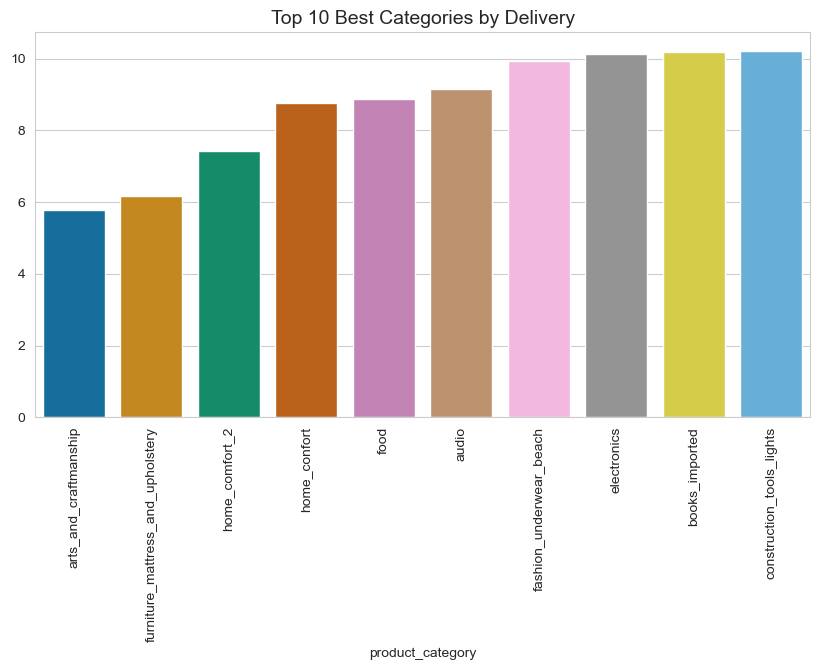

In [428]:
top_best_categories = df.groupby('product_category')['delivery_delta'].mean().nsmallest(10)

# barplot
plt.figure(figsize=(10,5))
sns.barplot(y=top_best_categories.values, x=top_best_categories.index, palette='colorblind', width=0.8)
plt.title("Top 10 Best Categories by Delivery", fontsize=14)
plt.savefig('../images/top_best_categories_by_delivery_bar.png', dpi=300)
plt.xticks(rotation='vertical')
plt.show()

## EDA: Product Performance (Identifying "Best" Categories)

To provide a balanced view, I also analyzed the "Top 10 Best Categories" by average `delivery_delta` (i.e., delivered fastest or most ahead of schedule).

* **Initial Finding:** The chart highlighted categories like `arts_and_craftmanship` and `furniture_mattress_and_upholstery` as top performers, with an average delivery delta of 6-7 days *early*.

* **The Critical Flaw:** I immediately recognized the same low-sample-size trap. These "top performers" are likely categories with very few sales, and their "fast" average is just statistical noise, not a reliable business insight.

* **Action:** This analysis is currently misleading. I will now re-run it with the same `n > 100` filter to identify the categories that are *both* popular *and* have a genuinely efficient, fast, and reliable delivery process.

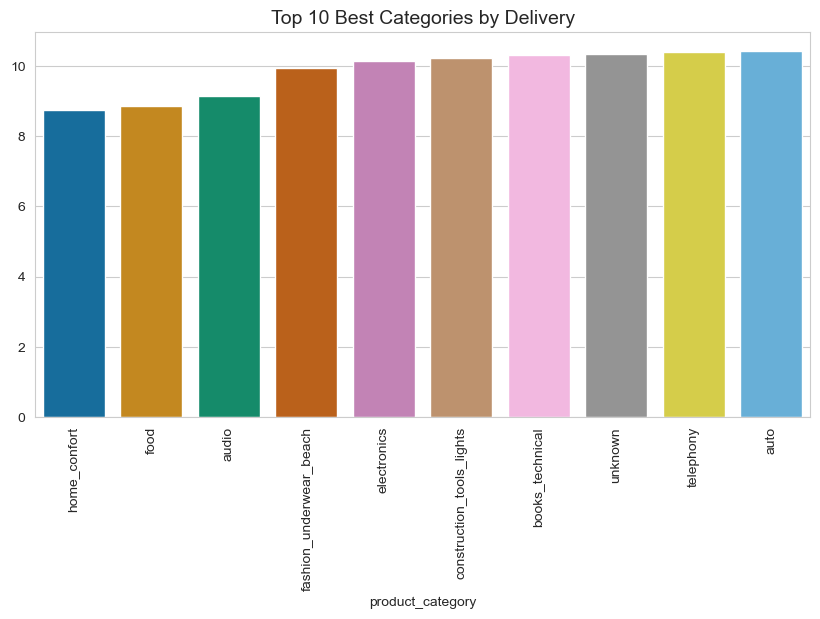

In [429]:
## getting categories with count > 100
temp_df = df['product_category'].value_counts().reset_index()
temp_df = temp_df[temp_df['count'] > 100]
top_categories = temp_df['product_category'].values
new_temp_df = df[df['product_category'].isin(top_categories)]

top_best_categories = new_temp_df.groupby('product_category')['delivery_delta'].mean().nsmallest(10)

# barplot
plt.figure(figsize=(10,5))
sns.barplot(y=top_best_categories.values, x=top_best_categories.index, palette='colorblind', width=0.8)
plt.title("Top 10 Best Categories by Delivery", fontsize=14)
plt.savefig('../images/top_best_categories_by_delivery_bar_main.png', dpi=300)
plt.xticks(rotation='vertical')
plt.show()

## EDA: Product Performance

After filtering for categories with > 100 sales, I re-ran the analysis to find the *true* top-performing categories by delivery.

* **Key Insight:** The `auto` category is the most reliable and efficient, with items arriving, on average, **more than 10 days *ahead* of schedule**.
* **Observation:** Other strong performers include `telephony`, `electronics`, and `books_technical`. This is a valuable insight: our high-tech and "auto" categories are not logistics problems; they are models of efficiency.
* **Business Impact:** The business should investigate *what* the sellers in these top categories are doing right. Do they use a specific logistics partner? Are they geographically clustered? We can learn from the success of the `auto` and `telephony` categories to improve the performance of laggards like `fashion_shoes`.